# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig
from torchvision import datasets, transforms
from torchvision import transforms
import os

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [2]:
# upload images to s3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(bucket)




sagemaker-us-east-1-722116367570


In [3]:
prefix = "dogImages"
# inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
inputs = "https://sagemaker-us-east-1-722116367570.s3.amazonaws.com/dogImages/"
print("input spec (in this case, just an S3 path): {}".format(inputs))


input spec (in this case, just an S3 path): https://sagemaker-us-east-1-722116367570.s3.amazonaws.com/dogImages/


In [4]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=2,
    instance_type="ml.c5.2xlarge",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [5]:
# location of training, test and validation data
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
# where model will be stored
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/" 
print(os.environ["SM_CHANNEL_TRAINING"])

s3://sagemaker-us-east-1-722116367570/dogImages/


In [4]:
# train the tuner to find the best values for learning rate and batch size
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [5]:
# run this cell if the session is disconnected and you don't want to rerun the tuning job but rather recover it from s3
tuner = HyperparameterTuner.attach("pytorch-training-230430-1926")


In [6]:
# grab the opetimal values for learning rate and batch size
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-30 20:06:51 Starting - Preparing the instances for training
2023-04-30 20:06:51 Downloading - Downloading input data
2023-04-30 20:06:51 Training - Training image download completed. Training in progress.
2023-04-30 20:06:51 Uploading - Uploading generated training model
2023-04-30 20:06:51 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.004528688040341531',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-30-19-26-46-633"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-04-30-19-26-46-633/source/sourcedir.tar.gz"'}

In [6]:
# store the optimal values so it can be used in training without a need to retrain the tuner
hyperparameter_optimal_values = {
 'batch-size': '"32"',
 'lr': '0.004528688040341531'
}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# setup the training job using the optimal hyperparameter values

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    entry_point="train_model.py",
    framework_version="1.11.0",
    py_version="py38",
    hyperparameters=hyperparameter_optimal_values,
    rules=rules,
    debugger_hook_config=hook_config,
)

estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)

session = boto3.session.Session()
region = session.region_name


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-05-04-00-53-18-112


2023-05-04 00:53:20 Starting - Starting the training job...
2023-05-04 00:53:47 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-05-04 00:54:27 Downloading - Downloading input data.........
2023-05-04 00:55:48 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-03 20:55:53,217 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-03 20:55:53,218 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-03 20:55:53,220 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-05-03 20:55:53,230 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-03 20:55

In [7]:
# recover the estimator so the previous steps not need to be rerun each time
estimator = PyTorch.attach("pytorch-training-2023-05-04-00-53-18-112")




2023-05-04 01:34:29 Starting - Preparing the instances for training
2023-05-04 01:34:29 Downloading - Downloading input data
2023-05-04 01:34:29 Training - Training image download completed. Training in progress.
2023-05-04 01:34:29 Uploading - Uploading generated training model
2023-05-04 01:34:29 Completed - Training job completed


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Checking Training Performance
Below is some boilerplate code to get the training job object using the training job name and display the training metrics that we were tracking as well as some of the training tensors. The plots may not show up in the classroom, but it will show up when you train the model in SageMaker Studio.

In [21]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()

if not debug_artifacts_path:
    debug_artifacts_path = 's3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/debug-output/'

trial = create_trial(debug_artifacts_path)

[2023-05-04 01:39:57.185 ip-172-16-182-150.ec2.internal:7308 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/debug-output/


Fetch tensor names and print their lengths


In [22]:
trial.tensor_names()

[2023-05-04 01:40:02.900 ip-172-16-182-150.ec2.internal:7308 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-05-04 01:40:03.921 ip-172-16-182-150.ec2.internal:7308 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [23]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

12

In [24]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


3

Set up functions to plot the output tensors


In [25]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    print(tensor)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    print(vals)
    return steps, vals

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[array(4.855488, dtype=float32), array(3.8954155, dtype=float32), array(2.5236268, dtype=float32), array(2.1496286, dtype=float32), array(1.596644, dtype=float32), array(2.1236775, dtype=float32), array(2.1340683, dtype=float32), array(2.0235376, dtype=float32), array(2.0739193, dtype=float32), array(2.1841698, dtype=float32), array(1.9697998, dtype=float32), array(2.354638, dtype=float32)]
loaded TRAIN data
[array(0.95638347, dtype=float32), array(1.5114868, dtype=float32), array(1.1312945, dtype=float32)]
loaded EVAL data
completed TRAIN plot
completed EVAL plot


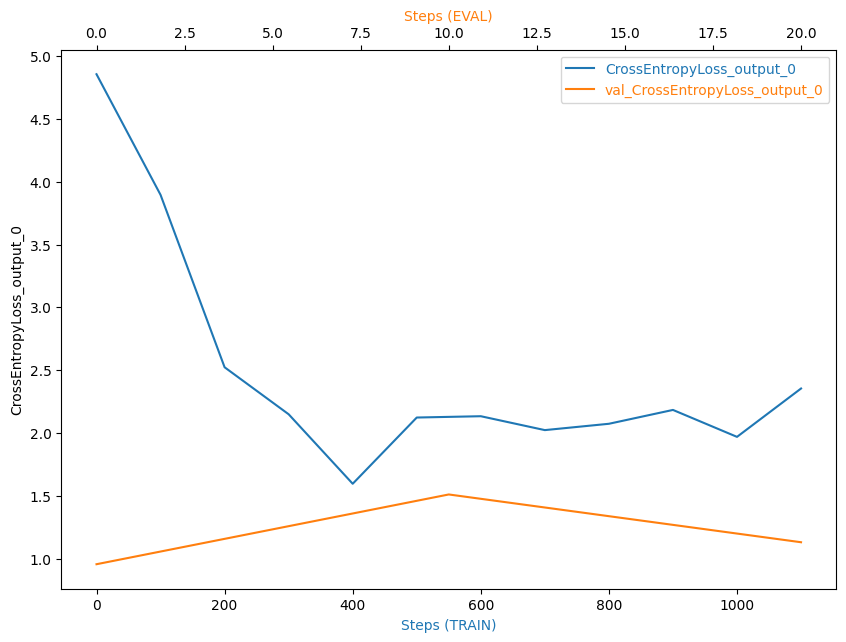

In [27]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


## Display the Profiler Report
The profiler report will be saved in an S3 bucket. Below we can see how to get the path of the report, fetch it and display it. The profiler report may not display in the notebook, but you can take a look at it from the ProfilerReport folder.

In [28]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)


s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/rule-output


In [29]:
! aws s3 ls {rule_output_path} --recursive


2023-05-04 01:34:10     329715 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-05-04 01:34:10     171074 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-05-04 01:34:06        192 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-05-04 01:34:06        200 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-05-04 01:34:06        126 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-05-04 01:34:06        127 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-05-04 01:34:06        199 pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-re

In [30]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-72211

In [34]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
print(estimator.latest_training_job.rule_job_summary())

[{'RuleConfigurationName': 'VanishingGradient', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-VanishingGradient-f1b4fc74', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2023, 5, 4, 1, 34, 23, 73000, tzinfo=tzlocal())}, {'RuleConfigurationName': 'Overfit', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-Overfit-f33a07f8', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2023, 5, 4, 1, 34, 23, 73000, tzinfo=tzlocal())}, {'RuleConfigurationName': 'Overtraining', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:722116367570:processing-job/pytorch-training-2023-05-0-Overtraining-e55a6fc5', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2023, 5, 4, 1, 34, 23, 73000, tzinfo=tzlocal())}, {'RuleConfigurationName': 'PoorWeightInitialization', 'RuleEvaluationJobArn': 'arn:aws:sag

In [35]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

# Model Deploying

In [8]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [9]:
model_location=estimator.model_data
# model_location = "s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/output/model.tar.gz"
print(model_location)

s3://sagemaker-us-east-1-722116367570/pytorch-training-2023-05-04-00-53-18-112/output/model.tar.gz


In [10]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=sagemaker.get_execution_role(), 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [11]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


-----!

In [12]:
with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)



In [14]:
response = predictor.predict(img_bytes)

In [15]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-19.97303581237793, -6.879031181335449, -15.934876441955566, -6.9927144050598145, -5.822351455688477, -13.995952606201172, -18.308286666870117, -20.51856231689453, -16.112934112548828, -6.006929874420166, -11.268488883972168, -1.6581330299377441, -15.861650466918945, -18.426664352416992, -15.329086303710938, -15.0988130569458, -16.09132957458496, -11.373177528381348, -23.878162384033203, -11.522068977355957, -11.681443214416504, -8.614819526672363, -5.049971580505371, -23.01412010192871, -16.21039390563965, -26.756145477294922, -17.00535774230957, -19.48587989807129, -6.655639171600342, -14.722195625305176, -2.891951322555542, -27.98619270324707, -22.043703079223633, -22.762378692626953, -11.07239055633545, -15.76267147064209, -11.004817962646484, -12.452240943908691, -13.50401782989502, -20.66962242126465, -24.932048797607422, -16.947246551513672, -4.627445220947266, -18.17559051513672, -7.993505954742432, -9.432415962219238, -13.608403205871582, -14.771100997

In [16]:
predictor.delete_endpoint()